In [53]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_moons
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# matplotlib  3.1.2
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [51]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')
    



In this lab, we will learn how to classify nonlinearly separable data by using **KNN and SVM classifiers.** Then, we will discuss how to handle missing values in the dataset, and how to encode categorical data. Finally, we will show how to pack multiple data preprocessing steps into into a single ```Pipeline``` in Scikit-learn to simplify the training workflow.



# Nonlinearly Separable Data

Sometimes, the classes in a dataset may be nonlinearly separable. A famous synthetic dataset in this category, called the two-moon dataset, can be illustrated in 2-D:

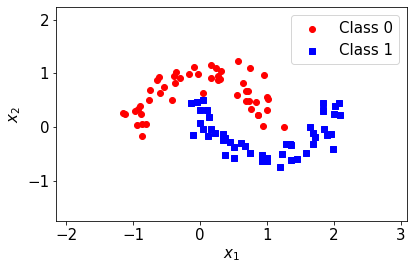

In [52]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=0)

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='r', marker='o', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='b', marker='s', label='Class 1')

plt.xlim(X[:, 0].min()-1, X[:, 0].max()+1)
plt.ylim(X[:, 1].min()-1, X[:, 1].max()+1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./output/fig-two-moon.png', dpi=300)
plt.show()

If we apply linear classifiers such as Perceptron or Logistic Regression to this dataset, it is not possible to get a reasonable decision boundary:



[Perceptron]
Misclassified samples: 3
Accuracy: 0.85


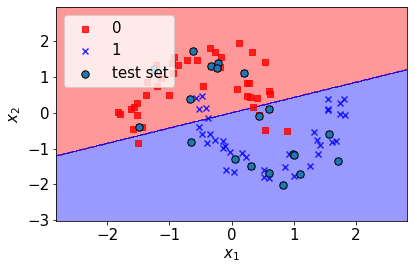

[Logistic regression]
Misclassified samples: 3
Accuracy: 0.85


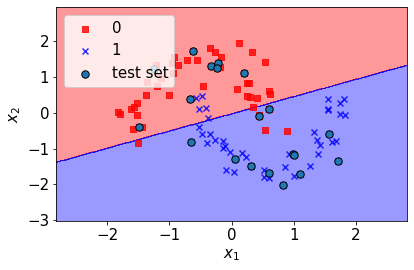

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

ppn = Perceptron(max_iter=1000, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('[Perceptron]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for Perceptron
plot_decision_regions(X_combined_std, y_combined,
                      classifier=ppn, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-perceptron-boundray.png', dpi=300)
plt.show()

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('[Logistic regression]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for LogisticRegression
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-logistic-regression-boundray.png', dpi=300)
plt.show()

As we can see, neither of the classifiers can separate the two classes well due to underfitting. In other words, the models are too simple to capture the shape of true boundary, introducing a large bias. It is better to use nonlinear classifiers for this dataset.



# K-Nearest Neighbors Classifier

The KNN algorithm itself is fairly straightforward and can be summarized by the following steps:

1. Choose number of neighbors,  $K$ , and a distance metric.
2. Find the  $K$  nearest neighbors of the data point that we want to classify.
3. Assign the class label by majority vote.

KNN is a typical example of a **lazy learner.** It is called lazy because it simply memorizes the training dataset in the training phase and learns a discriminative function  $f$  only before making a prediction.

By executing the following code, we will now implement a KNN model in scikit-learn using a Euclidean distance metric:

[KNN]
Misclassified samples: 1
Accuracy: 0.95


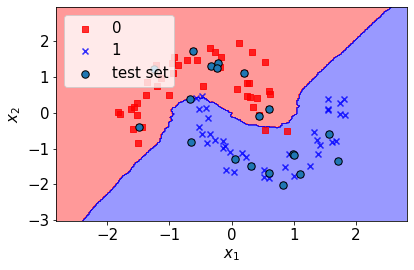

In [32]:
# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print('[KNN]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for knn classifier
plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, 
                      test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-knn-boundray.png', dpi=300)
plt.show()

The KNN classifier achieves 95% accuracy. That's pretty good! Another advantage of such a memory-based approach is that the classifier immediately adapts as we collect new training data.

However, the downside is that the computational complexity for classifying new points grows linearly with the number of samples in the training dataset in the worst-case scenario, unless the dataset has very few dimensions (features) and the algorithm has been implemented using efficient data structures such as KD-trees, an algorithm for finding best matches in logarithmic expected time. Furthermore, we can't discard training samples since no training step is involved. Thus, storage space can become a challenge if we are working with large datasets.

# Support Vector Classifier
Another powerful and widely used memory-based classifier is the nonlinear support vector classifier (SVC). Like KNN, nonlinear SVC makes predictions by the weighted average of the labels of similar examples (measured by a **kernel function**). However, only the **support vectors**, i.e., examples falling onto or inside the margin, can have positive weights and need to be remembered. In practice, SVC usually remembers much fewer examples than KNN does. Another difference is that SVC is not an lazy learner - the weights are trained eagerly in the training phase.

Let's make predictions using SVCs:

[Linear SVC]
Misclassified samples: 3
Accuracy: 0.85


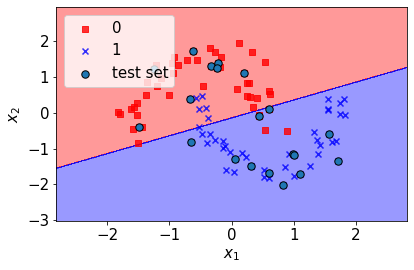

[Nonlinear SVC]
Misclassified samples: 1
Accuracy: 0.95


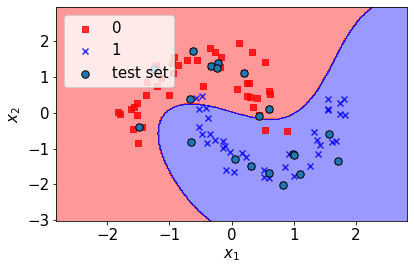

In [33]:
# kernel: the kernel function, can be 'linear', 'poly', 'rbf', ...etc
# C is the hyperparameter for the error penalty term
svm_linear = SVC(kernel='linear', C=1000.0, random_state=0)

svm_linear.fit(X_train_std, y_train)
y_pred = svm_linear.predict(X_test_std)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for linear svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm_linear, 
                      test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/figtwo-moon-svm-linear-boundray.png', dpi=300)
plt.show()

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_rbf = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0)

svm_rbf.fit(X_train_std, y_train)
y_pred = svm_rbf.predict(X_test_std)
print('[Nonlinear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm_rbf, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-svm-rbf-boundray.png', dpi=300)
plt.show()

As we can see, non-linear SVC achieves 95% accuracy as KNN does. However, we haven't tuned its hyperparameters to get the best performance yet. Let's try other values:



In [35]:
print('[Nonlinear SVC: C=1000, gamma=0.01]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1000.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

print('\n[Nonlinear SVC: C=10, gamma=0.0001]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.0001, C=10.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[Nonlinear SVC: C=1000, gamma=0.01]
Misclassified samples: 3
Accuracy: 0.85

[Nonlinear SVC: C=10, gamma=0.0001]
Misclassified samples: 11
Accuracy: 0.45


From the above example, we can see that tuning the hyperparameters is very important to nonlinear SVC. Different parameter setting will make huge performance difference.

## Tuning Hyperparameters via Grid Search
Tuning the hyperparameters of SVC is not as straightforward as we see in Polynomial Regression, where we can simply increase the polynomial degree from 1 and stop if the validation performance does not improve anymore. In SVC, there is no simple way to relate a particular hyperparameter combination  (C,γ)  to the model complexity. So, we have to try out all possible (or specified) combinations exhaustively in order to pick the best one. This procedure is called **grid search**:

In [36]:
param_C = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

svm = SVC(random_state=0)

# set the param_grid parameter of GridSearchCV to a list of dictionaries
param_grid = [{'C': param_C, 
               'gamma': param_gamma, 
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs = gs.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9625
{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}


After finding the best parameter, we can then use it to evaluate on test data:




[Nonlinear SVC: grid search]
Test accuracy: 1.00


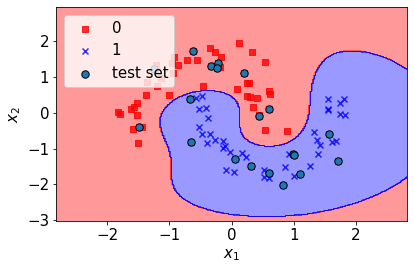

In [37]:
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('\n[Nonlinear SVC: grid search]')
print('Test accuracy: %.2f' % clf.score(X_test_std, y_test))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=gs.best_estimator_, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-svm-rbf-gs-boundray.png', dpi=300)
plt.show()

We have perfect test accuracy. That's great!

NOTE: grid search may consume a lot of time when the dataset is large. A practical way is to use **coarse grids** initially, narrow down into some grids that gives relatively good performance, and then perform more fine-grained grid searches within those grids recursively.

## Data Preprocessing
Now we have hands-on experience of many machine learning algorithms. It's time to apply them to a more realistic dataset with quality issues. Data quality and the amount of useful information in the dataset are key factors determining how well a machine learning algorithm can learn and/or predict. Therefore, it is critical for us to examine and **preprocess** a dataset before we feed it to a learning algorithm. The dataset we use in the following section is the [Adult](https://archive.ics.uci.edu/ml/datasets/adult) dataset.

### The Adult dataset
The Adult dataset from UCI repository collects information about people (attributes/features) for determining whether a person makes over 50K a year (label). Following are the attributes:

    1.  age               continuous.
    2.  workclass         Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, 
                          Without-pay, Never-worked.
    3.  fnlwgt            continuous.
    4.  education         Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 
                          9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    5.  education-num     continuous.
    6.  marital-status    Married-civ-spouse, Divorced, Never-married, Separated, Widowed, 
                          Married-spouse-absent, Married-AF-spouse.
    7.  occupation        Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, 
                          Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, 
                          Priv-house-serv, Protective-serv, Armed-Forces. 
    8.  relationship      Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    9.  race              White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    10. sex               Female, Male.
    11. capital-gain      continuous.
    12. capital-loss      continuous.
    13. hours-per-week    continuous.
    14. native-country    United-States, Cambodia, England, Puerto-Rico, Canada, Germany, 
                          Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, 
                          Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, 
                          Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, 
                          Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, 
                          Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
    15.  label            >50K, <=50K
    
You can see more details about the dataset [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/). Let's load the data:



In [38]:
# we set sep=', ' since this dataset is not a regular csv file
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'adult/adult.data', header=None, sep=', ', engine='python')

df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
              'education-num', 'marital-status', 'occupation', 
              'relationship', 'race', 'sex', 'capital-gain', 
              'capital-loss', 'hours-per-week', 'native-country', 
              'label']

display(df.head(15))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We can observe two things in this dataset:

1. Many attributes are not numeric but <font color="blue">**categorical.**</font>
2. There are <font color="blue">**missing values.**</font> For example, data point No.14 has a missing value on native-country.

Since most machine learning algorithms can only take datasets with numeric features and without missing values. We have to preprocess this dataset.

## Handling Categorical Data

Real-world datasets usually contain one or more categorical features. When we are talking about categorical data, we have to further distinguish between nominal and ordinal features. Ordinal features can be understood as categorical values that can be sorted or ordered. For example, T-shirt size would be an ordinal feature, because we can define an order XL > L > M. In contrast, nominal features don't imply any order. For example, we could think of T-shirt color as a nominal feature since it typically doesn't make sense to say that, for example, red is larger than blue.

In the Adult dataset, there is no obvious feature that is ordinal. So we will only focus on nominal ones in this lab. We can use the ```LabelEncoder``` in scikit-learn to help us encode categorical values into numerical values.

In [39]:
# encode label first
label_le = LabelEncoder()
df['label'] = label_le.fit_transform(df['label'].values)

# encode categorical features
catego_features = ['workclass', 'education', 'marital-status', 'occupation', 
                   'relationship', 'race', 'sex', 'native-country']

catego_le = LabelEncoder()

# transform categorical values into numerical values
# be careful that '?' will also be encoded
# we have to replace it to NaN in numerical
categories = []
for i in catego_features:
    df[i] = catego_le.fit_transform(df[i].values)
    classes_list = catego_le.classes_.tolist()
    
    # replace '?' with 'NaN'
    if '?' in classes_list:
        idx = classes_list.index('?')
        df[i] = df[i].replace(idx, np.nan)
    
    # store the total number of values
    categories.append(np.arange(len(classes_list)))

display(df.head(15))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7.0,77516,9,13,4,1.0,1,4,1,2174,0,40,39.0,0
1,50,6.0,83311,9,13,2,4.0,0,4,1,0,0,13,39.0,0
2,38,4.0,215646,11,9,0,6.0,1,4,1,0,0,40,39.0,0
3,53,4.0,234721,1,7,2,6.0,0,2,1,0,0,40,39.0,0
4,28,4.0,338409,9,13,2,10.0,5,2,0,0,0,40,5.0,0
5,37,4.0,284582,12,14,2,4.0,5,4,0,0,0,40,39.0,0
6,49,4.0,160187,6,5,3,8.0,1,2,0,0,0,16,23.0,0
7,52,6.0,209642,11,9,2,4.0,0,4,1,0,0,45,39.0,1
8,31,4.0,45781,12,14,4,10.0,1,4,0,14084,0,50,39.0,1
9,42,4.0,159449,9,13,2,4.0,0,4,1,5178,0,40,39.0,1


After executing the code, we successfully replaced the categorical values with numerical values.


## Dealing with Missing Data
It is common in real-world applications that our samples have missing values in one or more attributes due to various reasons. For example, there could have been an error in the data collection process, or certain measurements are not applicable, or particular fields could have been left blank intentionally in a survey, etc. We typically see missing values as the blank spaces, NaN, or question mark in our datasets.

Unfortunately, most computational tools are unable to handle such missing values or would produce unpredictable results if we simply ignored them. Therefore, it is crucial that we take care of those missing values before proceeding with further analysis.

First, we can use ```isnull()``` method in Panda's ```Dataframe``` to see how many missing values we have in Adult dataset:

In [40]:
# count the number of missing values per column
display(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
label                0
dtype: int64

For larger dataset, it can be tedious to look for missing values manually. In this case, we can use the ```isnull()``` method to return a ```DataFrame``` with Boolean values, where **True** represents data is missing. Using the ```sum()``` method, we can then return the number of missing values per column.

Next, we will discuss some common strategies to handle missing data.


## Eliminating Samples or Features with Missing Values
One of the easiest ways to deal with missing data is to simply remove the corresponding features (columns) or samples (rows) from the dataset entirely. We can call the ```dropna()``` method of ```Dataframe``` to eliminate rows or columns:

In [41]:
print(df.shape)

# drop rows with missing values
df_drop_row = df.dropna()
print(df_drop_row.shape)

(32561, 15)
(30162, 15)


The dropna method supports several additional parameters that can come in handy:



In [42]:
print('Original: {}'.format(df.shape))

# drop columns with missing values
df_drop_col = df.dropna(axis=1)
print('Drop column: {}'.format(df_drop_col.shape))

# drop rows or columns where all values are NaN
df_drop_row_all = df.dropna(how='all')
print('Drop row all: {}'.format(df_drop_row_all.shape))

# keep rows that have at least 14 non-NaN values
df_drop_row_thresh = df.dropna(thresh=14)
print('Drop row 14: {}'.format(df_drop_row_thresh.shape))

# only drop rows where NaN appear in specific columns (here: 'occupation')
df_drop_row_occupation = df.dropna(subset=['occupation'])
print('Drop row occupation: {}'.format(df_drop_row_occupation.shape))

Original: (32561, 15)
Drop column: (32561, 12)
Drop row all: (32561, 15)
Drop row 14: (30725, 15)
Drop row occupation: (30718, 15)


Although removal of missing data seems to be a convenient approach, it comes up with several disadvantages. For example, **dataset** might be too **small** as we remove number of samples, resulting in **overfitting.** Additionally, if we **eliminate too many features**, we will run the risk of **losing valuable relationship** between features that our classifier needs to discriminate between classes.



## Imputing Missing Values

If we do not have a large dataset, the removal of samples or dropping of entire feature columns may not be feasible, since we could lose valuable information. An alternative way is to use interpolation techniques to estimate the missing values from other training samples in the same dataset. There are some common interpolation techniques we can use, such as mean imputation, median imputation, and most frequent imputation.

The ```SimpleImputer``` class from scikit-learn provides a convenient way for imputation. Here we use it to perform the most frequent imputation since the missing values in the Adult dataset are all categorical features:

In [43]:
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)

df_impute = pd.DataFrame(imputed_data)
df_impute.columns = df.columns

display(df.head(15))
display(df_impute.head(15))

# check if there are still missing values
display(df_impute.isnull().sum())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7.0,77516,9,13,4,1.0,1,4,1,2174,0,40,39.0,0
1,50,6.0,83311,9,13,2,4.0,0,4,1,0,0,13,39.0,0
2,38,4.0,215646,11,9,0,6.0,1,4,1,0,0,40,39.0,0
3,53,4.0,234721,1,7,2,6.0,0,2,1,0,0,40,39.0,0
4,28,4.0,338409,9,13,2,10.0,5,2,0,0,0,40,5.0,0
5,37,4.0,284582,12,14,2,4.0,5,4,0,0,0,40,39.0,0
6,49,4.0,160187,6,5,3,8.0,1,2,0,0,0,16,23.0,0
7,52,6.0,209642,11,9,2,4.0,0,4,1,0,0,45,39.0,1
8,31,4.0,45781,12,14,4,10.0,1,4,0,14084,0,50,39.0,1
9,42,4.0,159449,9,13,2,4.0,0,4,1,5178,0,40,39.0,1


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39.0,7.0,77516.0,9.0,13.0,4.0,1.0,1.0,4.0,1.0,2174.0,0.0,40.0,39.0,0.0
1,50.0,6.0,83311.0,9.0,13.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,13.0,39.0,0.0
2,38.0,4.0,215646.0,11.0,9.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,40.0,39.0,0.0
3,53.0,4.0,234721.0,1.0,7.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,40.0,39.0,0.0
4,28.0,4.0,338409.0,9.0,13.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,40.0,5.0,0.0
5,37.0,4.0,284582.0,12.0,14.0,2.0,4.0,5.0,4.0,0.0,0.0,0.0,40.0,39.0,0.0
6,49.0,4.0,160187.0,6.0,5.0,3.0,8.0,1.0,2.0,0.0,0.0,0.0,16.0,23.0,0.0
7,52.0,6.0,209642.0,11.0,9.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,45.0,39.0,1.0
8,31.0,4.0,45781.0,12.0,14.0,4.0,10.0,1.0,4.0,0.0,14084.0,0.0,50.0,39.0,1.0
9,42.0,4.0,159449.0,9.0,13.0,2.0,4.0,0.0,4.0,1.0,5178.0,0.0,40.0,39.0,1.0


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

After executing the code, we successfully replaced the missing values into most frequent values.



## One-Hot Encoding
If we stop at this point and feed the array to our classifier, we will make one of the most common mistakes in dealing with categorical data. Take the 'workclass' for example, we will assume that 'State-gov' is larger than 'Self-emp-not-inc', and 'Self-emp-not-inc' is larger than 'Private'. This incorrect assumption can lead to degraded performance. For example, if a model uses weight decay for regularization, it may prefer categorical values that are encoded closer to  0 .

A common workaround for this problem is to use a technique called one-hot encoding. The idea behind this approach is to create a new dummy feature column for each unique value in the nominal feature. To perform this transformation, we can use the ```OneHotEncoder``` from Scikit-learn:

In [44]:
# we perform one-hot encoding on both impute data and drop-row data
impute_data = df_impute.values
drop_row_data = df_drop_row.values

# find the index of the categorical feature
catego_features_idx = []
for fea in catego_features:
    
    catego_features_idx.append(df.columns.tolist().index(fea))

# give the column index you want to do one-hot encoding
ohe = ColumnTransformer(
    [
        ("one_hot_encoder", OneHotEncoder(sparse = False, categories = "auto"), catego_features_idx)
    ],
    remainder = "passthrough"
)

impute_onehot_data = ohe.fit_transform(impute_data)
print('Impute: {}'.format(impute_data.shape))
print('Impute one-hot: {}'.format(impute_onehot_data.shape))

drop_row_onehot_data = ohe.fit_transform(drop_row_data)
print('Drop row: {}'.format(drop_row_data.shape))
print('Drop row one-hot: {}'.format(drop_row_onehot_data.shape))

Impute: (32561, 15)
Impute one-hot: (32561, 106)
Drop row: (30162, 15)
Drop row one-hot: (30162, 105)


Here, we can see that the numbers of column on both dataset increase significantly. Note that the number of columns between ```impute_onehot_data``` and ```drop_row_onehot_data``` are different, which implies that the drop-row method makes a value in a column disappear, resulting in loss of information.

NOTE: by default, the ```OneHotEncoder``` returns a sparse matrix when we use the transform() method. Sparse matrices save space to store entries with a lot of zeros.

# The ```get_dummies()``` Method in Pandas
An alternative, but more convenient way to create dummy features via one-hot encoding is to use the ```get_dummies()``` method implemented in Pandas.

NOTE: the ```get_dummies()``` method only converts string columns and leave all other columns unchanged. If you want to use this method, you have to ensure that the categorical data are all string. Otherwise it will not perform encoding.

In [45]:
df_dummy = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'adult/adult.data',
                 header=None, sep=', ', engine='python')

df_dummy.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                    'education-num', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'capital-gain', 
                    'capital-loss', 'hours-per-week', 'native-country', 
                    'label']

# encode label first
label_le = LabelEncoder()
df_dummy['label'] = label_le.fit_transform(df_dummy['label'].values)

# remove rows with missing data
df_dummy = df_dummy.replace('?', np.nan)
df_dummy_drop_row = df_dummy.dropna()
# here we cannot use sklearn.Imputer, since it only accepts numerical values

# one-hot encoding
df_dummy_drop_row = pd.get_dummies(df_dummy_drop_row)
display(df_dummy_drop_row.head())

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Scikit-learn Pipeline
When we applied different preprocessing techniques in the previous labs, such as standardization, data preprocessing, or PCA, you might notice that we have to reuse the parameters obtained during fitting the training data in order to scale and compress new data, ex. test data. Scikit-learn ```Pipeline``` allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions on new data. The following figure summarizes how Pipeline works:
![](https://nthu-datalab.github.io/ml/labs/07_SVM_Pipeline/fig-pipeline.png)

Here, we give an example on how to combine ```Imputer``` and ```OneHotEncoder``` with KNN or SVM:



In [46]:
df_small = df.sample(n = 4000, random_state = 0)

X = df_small.drop('label', axis=1).values
y = df_small['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

ohe = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
    ],
    remainder = "passthrough"
)

# define pipeline with an arbitrary number of transformer in a tuple array
pipe_knn = Pipeline([
    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ("ohe", ohe),
    ("scl", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors = 10, p = 2, metric = "minkowski"))
])

pipe_svm = Pipeline([
    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ("ohe", ohe),
    ("scl", StandardScaler()),
    ('clf', SVC(kernel = "rbf", random_state = 0, gamma = 0.001, C = 100.0))
])

# use the pipeline model to train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN]
Misclassified samples: 158
Accuracy: 0.8025

[SVC]
Misclassified samples: 134
Accuracy: 0.8325


We can check whether one-hot encoding is useful or not:



In [47]:
pipe_knn = Pipeline([
    ('imr', SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ('scl', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski'))
])

pipe_svm = Pipeline([
    ('imr', SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ('scl', StandardScaler()),
    ('clf', SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0))
])

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN: no one-hot]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC: no one-hot]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN: no one-hot]
Misclassified samples: 156
Accuracy: 0.8050

[SVC: no one-hot]
Misclassified samples: 151
Accuracy: 0.8113


As we can see, the performance of **KNN does not change much** because the model has no preference on specific numerical values. On the other hand, the **accuracy drops in SVC** because it has a weight decay term in the cost function that can be misled when the categorical features are not encoded as one-hot vectors.

We can also compare the performance between imputation and dropping rows:

In [48]:
# keep only data points without NaN features
idx = np.isnan(X_train).sum(1) == 0
X_train = X_train[idx]
y_train = y_train[idx]
idx = np.isnan(X_test).sum(1) == 0
X_test = X_test[idx]
y_test = y_test[idx]

ohe = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
    ],
    remainder = "passthrough"
)

pipe_knn = Pipeline([
                    ('ohe', ohe),
                    ('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski'))
])

pipe_svm = Pipeline([
                    ('ohe', ohe),
                    ('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0))
])

# use the pipeline model to train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN: drop row]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC: drop row]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN: drop row]
Misclassified samples: 148
Accuracy: 0.8008

[SVC: drop row]
Misclassified samples: 126
Accuracy: 0.8304


We get only slightly worse results than imputation since we have a large enough dataset.

Finally, let's combine SVC pipeline with grid search:

In [49]:
pipe_svm = Pipeline([
                    ('ohe',
                        ColumnTransformer(
                            [
                                ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
                            ],
                            remainder = "passthrough"
                        )
                    ),
                    ('scl', StandardScaler()),
                    ('clf', SVC(random_state=0))
])

param_gamma = [0.0001, 0.001, 0.01, 0.1, 1.0]
param_C = [0.1, 1.0, 10.0, 100.0]

# here you can set parameter for different steps 
# by adding two underlines (__) between step name and parameter name
param_grid = [{'clf__C': param_C, 
               'clf__kernel': ['linear']},
              {'clf__C': param_C, 
               'clf__gamma': param_gamma, 
               'clf__kernel': ['rbf']}]

# set pipe_svm as the estimator
gs = GridSearchCV(
    estimator = pipe_svm, 
    param_grid = param_grid, 
    scoring = "accuracy",
    cv = 3
)

gs = gs.fit(X_train, y_train)
print('[SVC: grid search]')
print('Validation accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

[SVC: grid search]
Validation accuracy: 0.835
{'clf__C': 100.0, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Test accuracy: 0.830
